In [69]:
%matplotlib inline
import seaborn
import sys
import logbook
import numpy as np
from datetime import datetime
import pytz
import pyfolio as pf
import pandas as pd

from zipline.algorithm import TradingAlgorithm
from zipline.utils.factory import load_from_yahoo
from zipline.finance import commission
from zipline.api import order_target, record, symbol, history, schedule_function, date_rules,time_rules,order_target_percent
from zipline.data.bundles import register, yahoo_equities

In [70]:
STOCKS=['TLT','SPY']

In [74]:
import pandas as pd

def initialize(context):
    context.i =0
    """
    initialize() is called once at the start of the program. Any one-time
    startup logic goes here.
    """
    context.security_list = [symbol('SPY'),symbol('TLT')]
    
    # Rebalance every Monday (or the first trading day if it's a holiday)
    # at market open.
    schedule_function(rebalance,
                      date_rules.every_day(),
                      time_rules.market_open())

    # Record variables at the end of each day.
    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())

def compute_weights(context, data):
    """
    Compute weights for each security that we want to order.
    """
    # Get the 30-day price history for each security in our list.
    hist = data.history(context.security_list, 'price', 25, '1d')
    
    raw = 10.0/ pd.ewmstd(hist,15).tail(1).iloc[0,:]
    normalized_weights = raw / raw.abs().sum()
    
    # Return our normalized weights. These will be used when placing orders later.
    return normalized_weights

def rebalance(context, data):
    """
    This function is called according to our schedule_function settings and calls
    order_target_percent() on every security in weights.
    """
    context.i += 1
    if context.i < 100:
        return
    
    # Calculate our target weights.
    weights = compute_weights(context, data)

    # Place orders for each of our securities.
    for security in context.security_list:
        if data.can_trade(security):
            order_target_percent(security, weights[security])

def record_vars(context, data):
    """
    This function is called at the end of each day and plots our leverage as well
    as the number of long and short positions we are holding.
    """
    # Record our variables.
    record(TLT=context.portfolio.positions[symbol('TLT')].amount, SPY=context.portfolio.positions[symbol('SPY')].amount)

In [78]:
start = datetime(2009, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2015, 1, 1, 0, 0, 0, 0, pytz.utc)
data = load_from_yahoo(stocks=STOCKS, indexes={}, start=start, end=end)
data = data.dropna()


In [79]:
rp = TradingAlgorithm(handle_data=rebalance, initialize=initialize)
results = rp.run(data)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:29: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=0,adjust=True,com=15).std(bias=False)
/Users/mrefermat/anaconda/lib/python2.7/site-packages/zipline/finance/risk/period.py:100: FutureWarning: pd.rolling_count is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=60).count()
  self.algorithm_returns, self.num_trading_days)
/Users/mrefermat/anaconda/lib/python2.7/site-packages/zipline/finance/risk/period.py:100: FutureWarning: pd.rolling_count is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=123).count()
  self.algorithm_returns, self.num_trading_days)
/Users/mrefermat/anaconda/lib/python2.7/site-packages/zipline/finance/risk/period.py:100: FutureWarning: pd.rolling_count is deprecated for Series and w

Entire data start date: 2009-01-02
Entire data end date: 2014-12-31


Out-of-Sample Months: 26
Backtest Months: 45


Performance statistics,All history,Backtest,Out of sample
annual_return,0.14,0.17,0.10
annual_volatility,0.08,0.09,0.08
sharpe_ratio,1.63,1.79,1.35
calmar_ratio,1.74,2.71,1.27
stability_of_timeseries,0.99,0.98,0.93
max_drawdown,-0.08,-0.06,-0.08
omega_ratio,1.32,1.36,1.24
sortino_ratio,2.48,2.81,1.89
skew,0.09,0.29,-0.51
kurtosis,2.16,2.34,1.03


Worst Drawdown Periods,net drawdown in %,peak date,valley date,recovery date,duration
0,8.11,2013-05-02,2013-08-21,2014-02-26,215
1,6.10,2009-04-01,2009-05-27,2009-07-31,88
2,5.06,2010-10-06,2010-12-15,2011-03-30,126
3,3.96,2009-11-25,2010-02-18,2010-04-21,106
4,3.61,2011-05-31,2011-06-29,2011-08-02,46




[-0.01  -0.018]


/Users/mrefermat/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


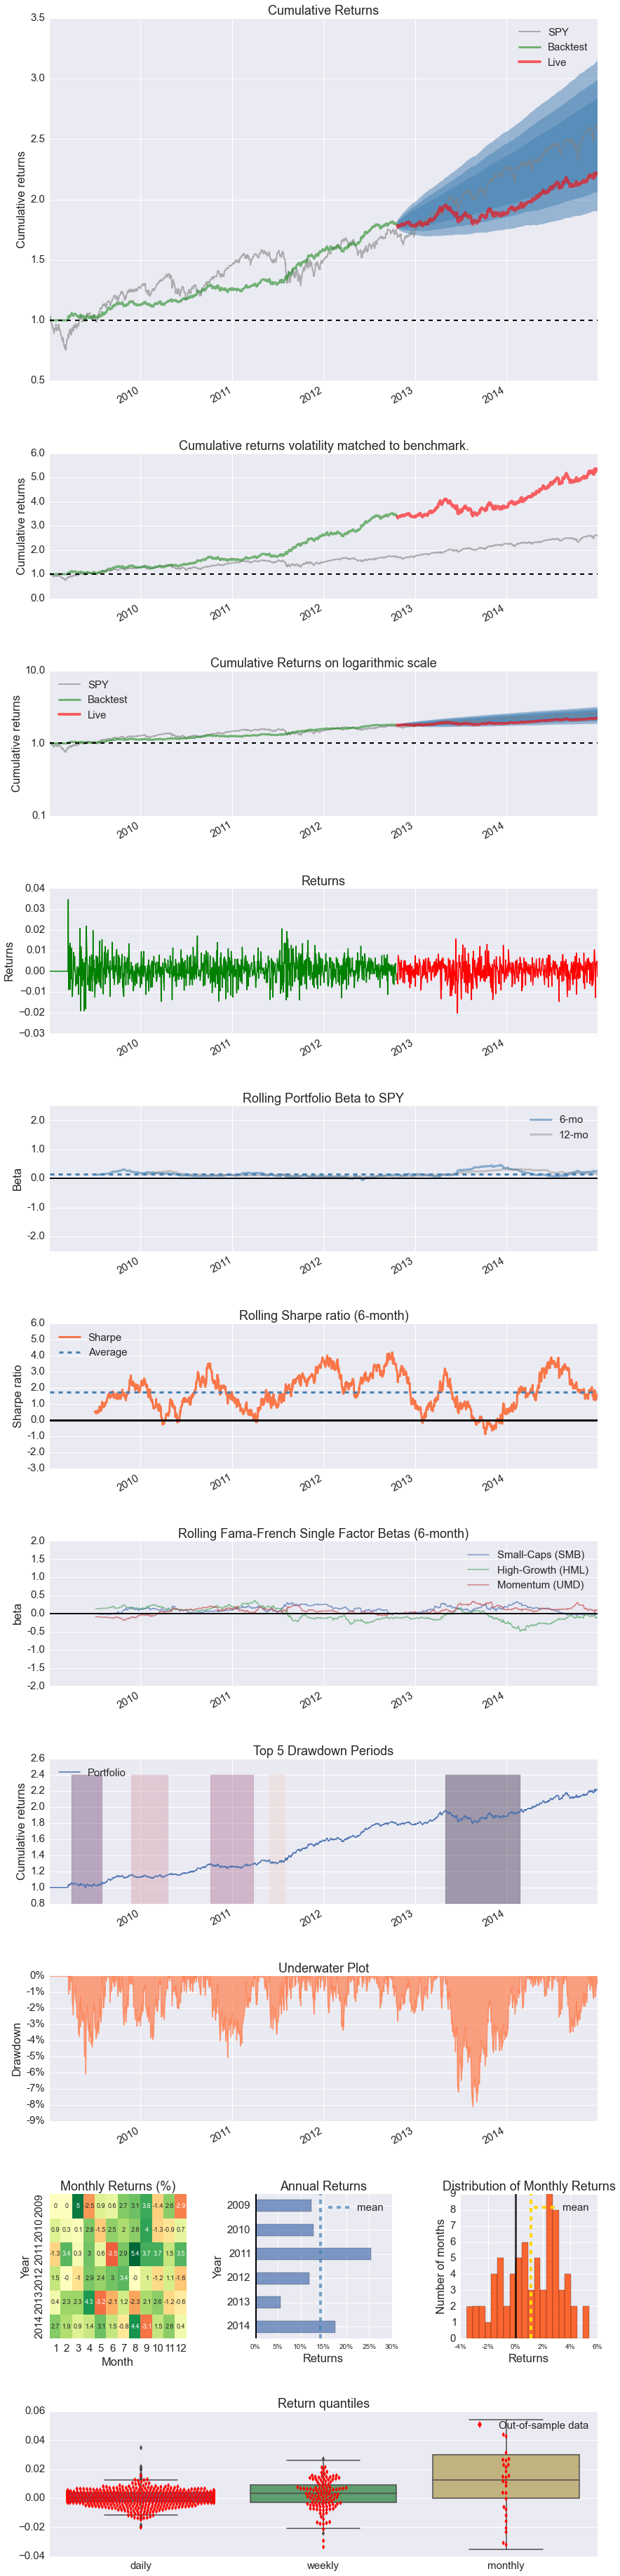

/Users/mrefermat/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Stress Events,mean,min,max
US downgrade/European Debt Crisis,0.22%,-1.38%,1.92%
Fukushima,0.10%,-0.78%,1.13%
EZB IR Event,-0.01%,-1.13%,0.80%
2009Q1,0.00%,0.00%,0.00%
2009Q2,0.06%,-1.91%,3.46%
Flash Crash,-0.15%,-1.38%,1.13%
Apr14,0.09%,-0.68%,0.65%
Oct14,0.07%,-1.11%,0.88%
GFC Crash,0.10%,-0.90%,3.46%
Recovery,0.06%,-1.91%,2.19%


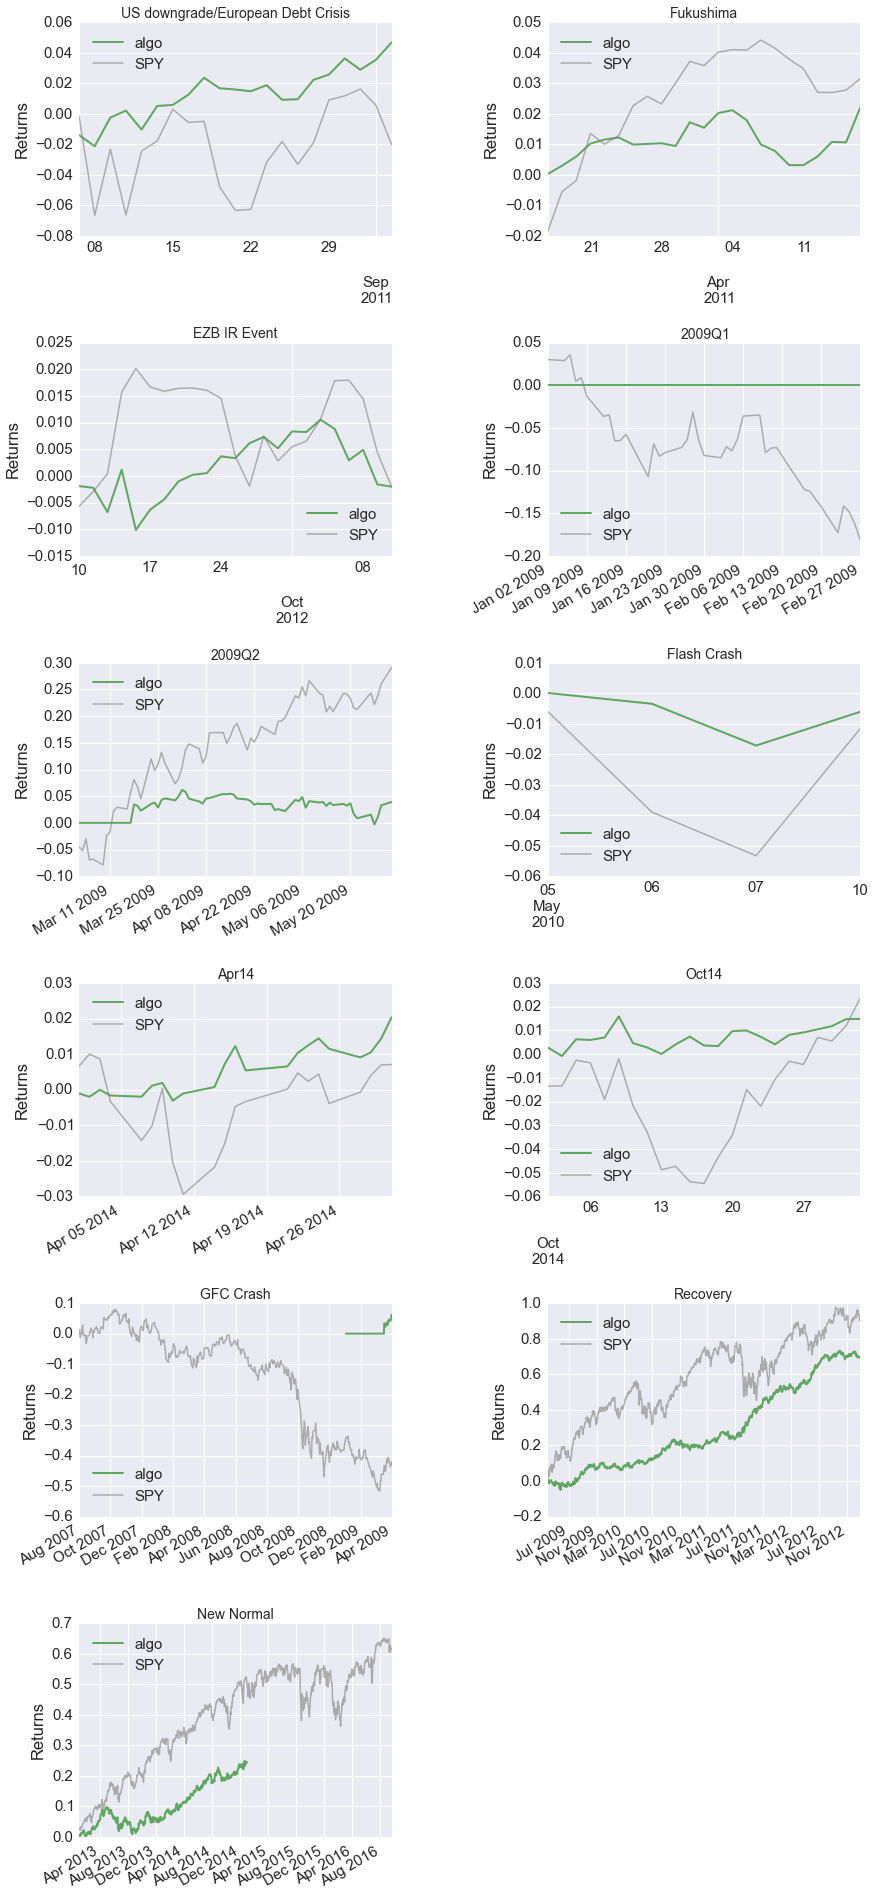

Top 10 long positions of all time,max
sid,
Equity(1 [TLT]),96.32%
Equity(0 [SPY]),80.75%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
Equity(1 [TLT]),96.32%
Equity(0 [SPY]),80.75%


All positions ever held,max
sid,
Equity(1 [TLT]),96.32%
Equity(0 [SPY]),80.75%


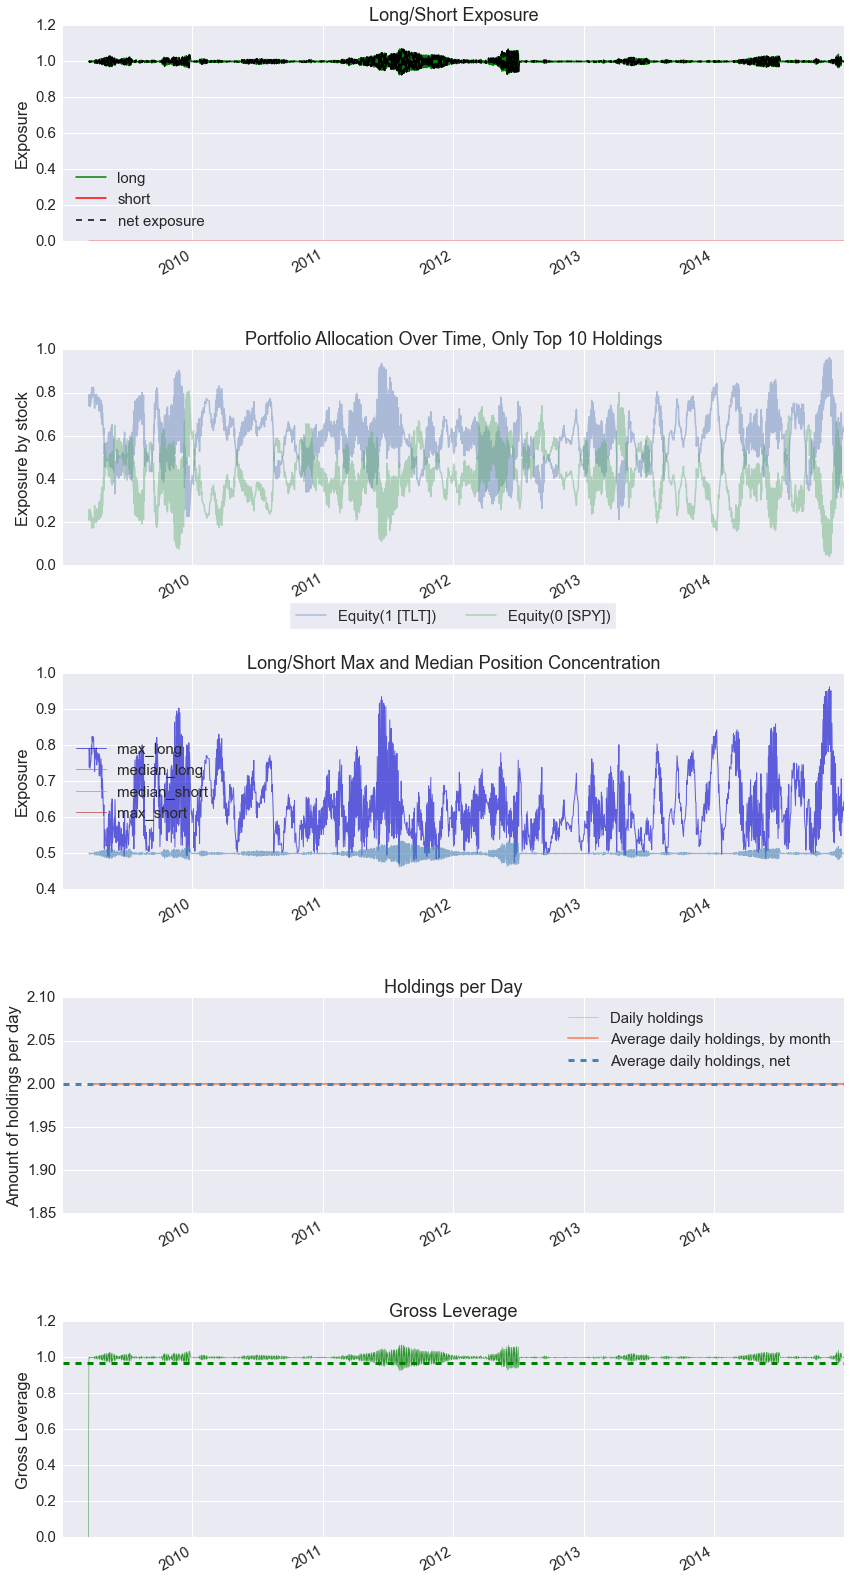

/Users/mrefermat/anaconda/lib/python2.7/site-packages/pyfolio/plotting.py:1210: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  **kwargs)


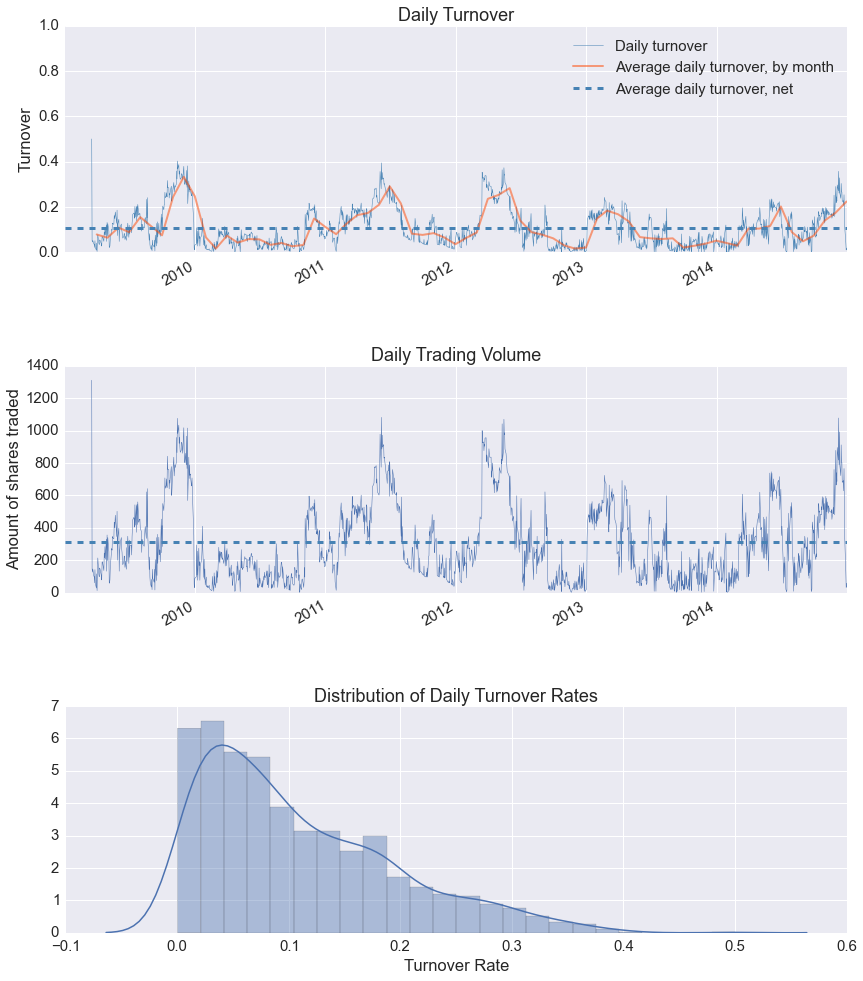

Summary stats,All trades,Long trades
Total number of round_trips,1452.00,1452.00
Percent profitable,0.62,0.62
Winning round_trips,905.00,905.00
Losing round_trips,547.00,547.00
Even round_trips,0.00,0.00


PnL stats,All trades,Long trades
Total profit,$127333.41,$127333.41
Gross profit,$294695.64,$294695.64
Gross loss,$-167362.24,$-167362.24
Profit factor,$1.76,$1.76
Avg. trade net profit,$87.70,$87.70
Avg. winning trade,$325.63,$325.63
Avg. losing trade,$-305.96,$-305.96
Ratio Avg. Win:Avg. Loss,$1.06,$1.06
Largest winning trade,$3090.32,$3090.32
Largest losing trade,$-2667.68,$-2667.68


Duration stats,All trades,Long trades
Avg duration,22 days 05:58:00.992424,22 days 05:58:00.992424
Median duration,17 days 00:00:00,17 days 00:00:00
Avg # round_trips per day,16.13,16.13
Avg # round_trips per month,338.80,338.80


Return stats,All trades,Long trades
Avg returns all round_trips,0.06%,0.06%
Avg returns winning,0.21%,0.21%
Avg returns losing,-0.21%,-0.21%
Median returns all round_trips,0.04%,0.04%
Median returns winning,0.14%,0.14%
Median returns losing,-0.12%,-0.12%
Largest winning trade,1.96%,1.96%
Largest losing trade,-1.70%,-1.70%


Symbol stats,Equity(0 [SPY]),Equity(1 [TLT])
Avg returns all round_trips,0.06%,0.05%
Avg returns winning,0.20%,0.23%
Avg returns losing,-0.19%,-0.22%
Median returns all round_trips,0.04%,0.03%
Median returns winning,0.14%,0.15%
Median returns losing,-0.11%,-0.14%
Largest winning trade,1.61%,1.96%
Largest losing trade,-0.99%,-1.70%


Profitability (PnL / PnL total) per name,pnl
symbol,
Equity(0 [SPY]),0.53%
Equity(1 [TLT]),0.47%


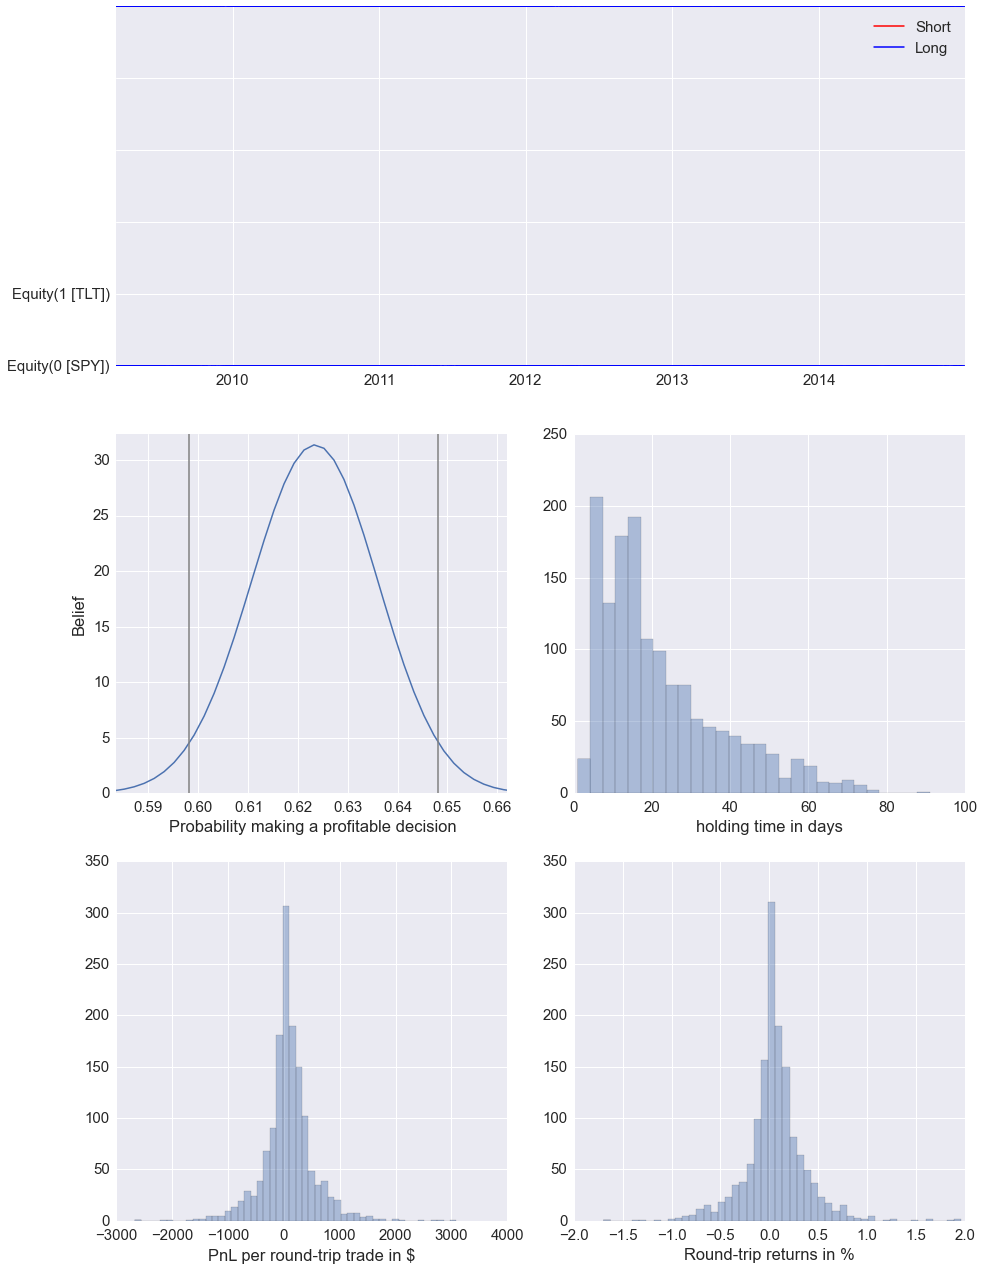

In [80]:
returns, positions, transactions, gross_lev = pf.utils.extract_rets_pos_txn_from_zipline(results)
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions,
                          gross_lev=gross_lev, live_start_date='2012-10-22', round_trips=True)